In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Implement a code to solve the full Hamiltonian

The system is of the form: 
$$
\begin{align}
dq&=pdt \\
dp&= F(q) dt - \gamma p dt + \sqrt{2 \frac{\gamma}{\beta}} dW
\end{align}
$$
with $F(q)= q^2/2$.



In [45]:
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/fullhamiltonian.py"

<Figure size 432x288 with 0 Axes>

In [39]:
T=10
h = 0.1
gamma = 1
beta=10000
# compile
N=1
%time qp=method_baoab(T,gamma,beta,h,N)
# run for 1 no compiler 
N=1
%time qp=method_baoab(T,gamma,beta,h,N)


CPU times: user 1.87 s, sys: 7.99 ms, total: 1.88 s
Wall time: 1.61 s
CPU times: user 1.79 ms, sys: 12 µs, total: 1.8 ms
Wall time: 637 µs


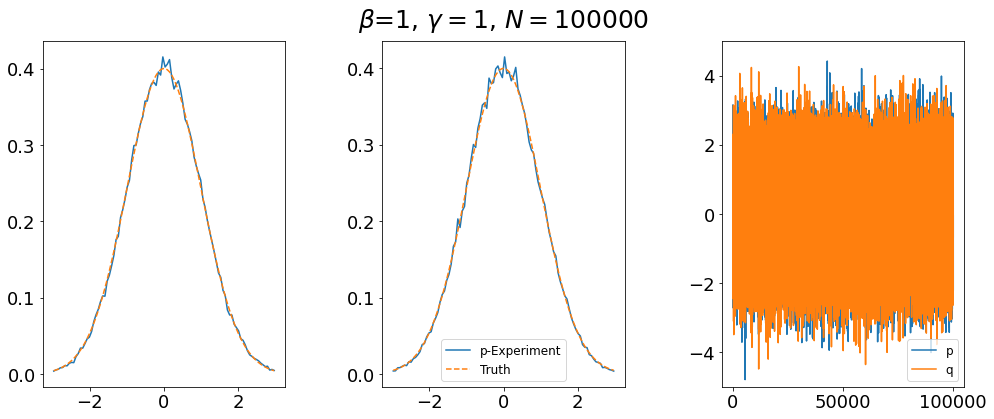

In [47]:
T=10
h = 0.1
gamma = 1
beta=1
N=10**5
qp1=method_baoab(T,gamma,beta,h,N)
plot_qp(qp1,beta,gamma)


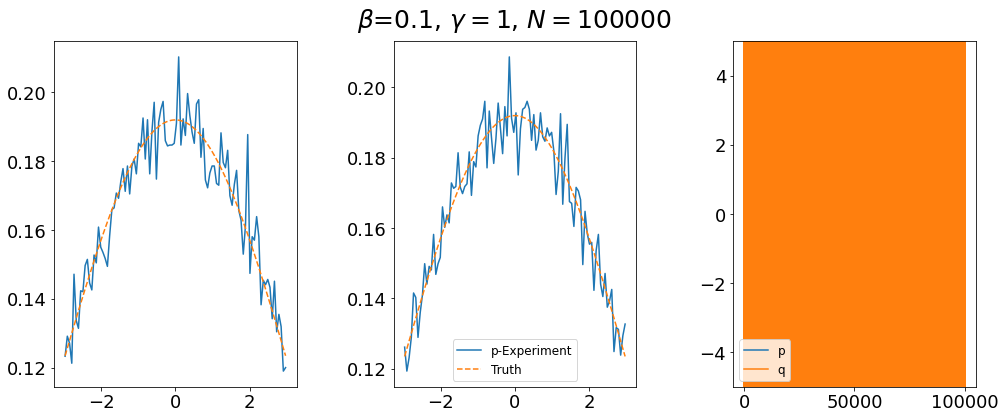

In [51]:
T=10
h = 0.1
gamma = 1
beta=0.1
N=10**5
qp2=method_baoab(T,gamma,beta,h,N)
plot_qp(qp2,beta,gamma)

When $\beta$ get smaller, the noise is higher and the upper bounds on the stability of the numerical method is higher, or you need a smaller time steps to achieve the same accuracy. When $\gamma$ is smaller, the speed of convergence is lower and you need to go further in time to get closer to the invariant distribution ! 

One can look at the stability property of the BAOAB method applied to the SDE ref sde of interest. 
Step A and B do not have any conditions on $\Delta t$: 
Step A : 
$$
q_{n+1}=q_{n}+p_n \Delta t \\
\rightarrow q_{n+1} = q_0 + \Delta t \sum_i^{n} p_i 
$$
Step B : 
$$
p_{n+1}=p_{n}+F(q_n) \Delta t \\
\rightarrow p_{n+1} = p_0 + \Delta t \sum_i^{n} F(q_i) 
$$
where the conditions on $\Delta t$ regarding stability properties is $\Delta t <1$ and $\Delta t>0$. To see that, we look at equation where $F(x) \approx a+bx$, we use taylor expansion to get an approximation of the function $F$ around the roots. One can plug equation ref at $n$ into equation ref at step $n+1$ and once again equation 1 at steps $n-2$:
$$ 
q_{n+1} = q_0 + \Delta t n p_0 + \Delta t^2 b \left(\frac{n(n-1)}{2} \right) + a \Delta t^2 q_0 \left( \frac{n(n+1)}{2} - (n-2) \right) + a\Delta t^3 \sum_{i=1}^n \sum _{j=1}^{i-1} \sum_{k=1}^{j-1} p_k
$$
where we can see that the term $\Delta t$ appears as a power and therefore the stability condition are $\Delta t<1$.

Regarding step 0, we have: 
$$
p_{n+1} = \exp(-\gamma \Delta t) p_n + \sqrt{(1-\exp(-2 \gamma \Delta t)\beta^{-1})} \mathcal{N}(0,1).
$$
We can the stability property of the numerical method:   
$$
\mathbb{E} p_{n+1} = \mathbb{E} p_{n} \exp(-\gamma \Delta t) \\
\rightarrow  \mathbb{E} p_{n+1} = \mathbb{E} p_{0} \exp(-\gamma \Delta t n).
$$
For any $\Delta t>0$, $\lim_{n \to \infty}  p_{0} \exp(-\gamma \Delta t n) =0 $. The convergence depends on the size of $\gamma$. If $\gamma$ is higher, the numerical scheme will converge faster. Regarding the variance, we obtain: 
$$
\mathbb{V} [p_{n+1} ]= \mathbb{E} [p_{n+1}^2] - \left( \mathbb{E} [p_{n+1}]\right)^2 \\
\rightarrow  \mathbb{E} [p_{n+1}] = \left(\mathbb{E} [p_{n}^2] - \left( \mathbb{E} [p_{n}]\right)^2\right) \exp(-2 h \gamma n) + \beta^{-2} (1-\exp(-2 \gamma h)) \sum_{i=0}^{n} \exp(-2h \gamma i) \\
\rightarrow  \mathbb{Var} [p_{n+1}] = \mathbb{Var} [p_{n}] \exp(-2 h \gamma n) + \beta^{-2} (1-\exp(-2 \gamma h)) \sum_{i=0}^{n} \exp(-2h \gamma i)
$$
where we can see that the sheme should converge for any values of $\gamma$ and $\beta$ ultimately. However, when the value of $\gamma$ increases, the scheme requires a smaller time steps to achieve the same speed of convergence, while $\beta$ guides the size of the upper bound and a higher $\beta$ means that you are requires to go further in time to reach the invariant distribution. 


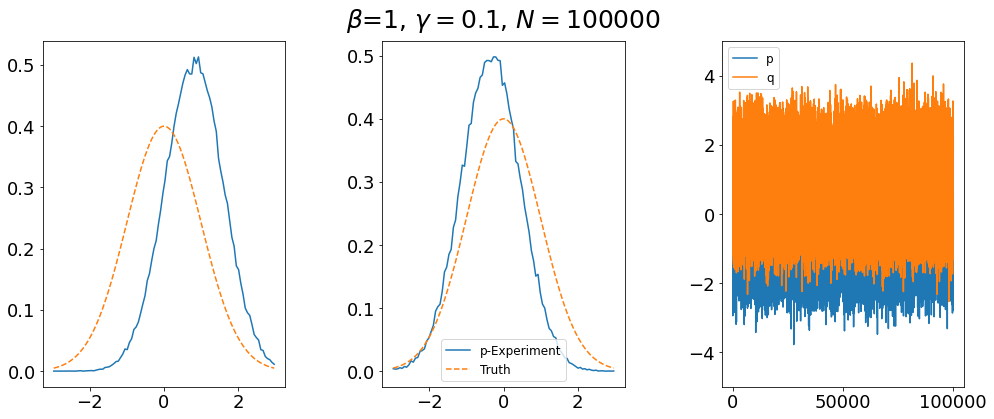

In [49]:
T=10
h = 0.1
gamma = 0.1
beta=1
N=10**5
qp3=method_baoab(T,gamma,beta,h,N)
plot_qp(qp3,beta,gamma)

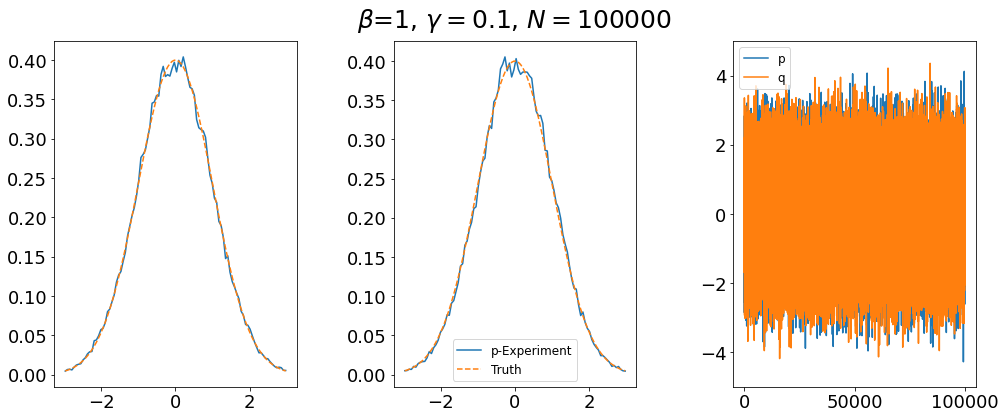

In [50]:
T=100
h = 0.1
gamma = 0.1
beta=1
N=10**5
qp4=method_baoab(T,gamma,beta,h,N)
plot_qp(qp4,beta,gamma)

## Compute observable 

To have interesting observable, it would be good to look at values of beta, gamma and h that are interesting for the research. 


In [ ]:
q=qp_np[::,0]
p=qp_np[::,1]
def esc_prop(p,a,b):
    res = len(p[p<a])+len(p[p>b])
    res = res/len(p)
    return(res)
print(esc_prop(p,-10,10))
print(esc_prop(q,0,3))

In [ ]:
## Try different values 
T=10
h = 0.0001
gamma = 1
beta=1
qp=method_baoab(T,gamma,beta,h,N)
q_test=qp_np[::,0]
p_test=qp_np[::,1]
print(esc_prop(p_test,-10,10))
print(esc_prop(q_test,0,3))

In [ ]:
def nesc_eta_dtlist(n_samples,dt_var,gamma,beta,T,method):
    """
    Function to establish the proportion of escaping trajectories
    Input :
    ------
    n_samples: int
        number of samples generated
    dt: float
        Time increment
    list_var: list of float
        list of values of the temperature to evaluate 
    T: int
        Final time until the solution is ran
    b: int
        Boundary selected
    """
    # empty vector to save results
    y_res = np.zeros((len(dt_var),n_samples))
    #list of escaping trajectories
    nesc_list=[]
    #run through the different values of tau 
    for i in range(len(dt_var)):
        dt_i=dt_var[i]
        pq_exact = method_baoab(T,gamma,beta,h,N)
        y_res[i,::]=        pq_exact = method_baoab(T,gamma,beta,h,N)


        #compute the proportion of escaping trajectory
        res = len(y_exact[y_exact<0])+len(y_exact[y_exact>b])
        res = res/len(y_exact)
        nesc_list.append(res)
        
    return(nesc_list,y_res)

In [ ]:
 #compute the proportion of escaping trajectory
res = len(y_exact[y_exact<0])+len(y_exact[y_exact>b])
        res = res/len(y_exact)
        nesc_list.append(res)